# Time Series Linear Regression Algorithm

This algorithm is used to forecast FOREX prices for the USDJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hour


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")
import ta
import seaborn as sns
import MetaTrader5 as mt5
from datetime import datetime
from UsefulFunctions import data

In [3]:
# Initiate bound between MetaTrader5 and Python
mt5.initialize()

True

In [4]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("USDJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,120.420,120.440,120.330,120.390,262,30,0
2015-01-02 09:00:00,120.400,120.500,120.380,120.430,599,30,0
2015-01-02 10:00:00,120.440,120.480,120.340,120.340,832,30,0
2015-01-02 11:00:00,120.330,120.420,120.310,120.400,761,30,0
2015-01-02 12:00:00,120.410,120.470,120.370,120.430,484,30,0
...,...,...,...,...,...,...,...
2024-08-07 12:00:00,147.193,147.626,147.078,147.567,7534,17,0
2024-08-07 13:00:00,147.568,147.599,147.035,147.186,5840,18,0
2024-08-07 14:00:00,147.184,147.496,146.979,147.194,5096,17,0


In [46]:
# Create a copy of the original DataFrame and reduce it to close values only for feature engineering
df_copy = df.copy()
df_copy = df_copy[["close"]]
df_copy

,close
time,
2015-01-02 08:00:00,120.390
2015-01-02 09:00:00,120.430
2015-01-02 10:00:00,120.340
2015-01-02 11:00:00,120.400
2015-01-02 12:00:00,120.430
...,...
2024-08-07 12:00:00,147.567
2024-08-07 13:00:00,147.186
2024-08-07 14:00:00,147.194


In [48]:
# Here I added a new column with the percent change between the close price and the previous close price
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy

,close,pct_change
time,,
2015-01-02 08:00:00,120.390,NaN
2015-01-02 09:00:00,120.430,0.000332
2015-01-02 10:00:00,120.340,-0.000747
2015-01-02 11:00:00,120.400,0.000499
2015-01-02 12:00:00,120.430,0.000249
...,...,...
2024-08-07 12:00:00,147.567,0.002548
2024-08-07 13:00:00,147.186,-0.002582
2024-08-07 14:00:00,147.194,0.000054


## In the next section I started working on feature engineering and added more technical indicators

In [51]:
# Here were added columns with shifted values of the pct_change column
# The function "add_shifted_columns" was added to the data.py file 

df_copy = data.add_shifted_columns(df_copy,4, "pct_change")
df_copy

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago
time,,,,,,
2015-01-02 08:00:00,120.390,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,120.430,0.000332,NaN,NaN,NaN,NaN
2015-01-02 10:00:00,120.340,-0.000747,0.000332,NaN,NaN,NaN
2015-01-02 11:00:00,120.400,0.000499,-0.000747,0.000332,NaN,NaN
2015-01-02 12:00:00,120.430,0.000249,0.000499,-0.000747,0.000332,NaN
...,...,...,...,...,...,...
2024-08-07 12:00:00,147.567,0.002548,0.003504,0.000716,-0.002722,-0.004295
2024-08-07 13:00:00,147.186,-0.002582,0.002548,0.003504,0.000716,-0.002722
2024-08-07 14:00:00,147.194,0.000054,-0.002582,0.002548,0.003504,0.000716


In [53]:
# A Simple Moving Average indicator was created and shifted one row so the outcome value of the previous time stamp
# make sence to predict the current value

df_copy["SMA 7"] = df_copy["close"].rolling(7).mean().shift(1)
df_copy.head(10)

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago,SMA 7
time,,,,,,,
2015-01-02 08:00:00,120.39,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,120.43,0.000332,NaN,NaN,NaN,NaN,NaN
2015-01-02 10:00:00,120.34,-0.000747,0.000332,NaN,NaN,NaN,NaN
2015-01-02 11:00:00,120.40,0.000499,-0.000747,0.000332,NaN,NaN,NaN
2015-01-02 12:00:00,120.43,0.000249,0.000499,-0.000747,0.000332,NaN,NaN
2015-01-02 13:00:00,120.47,0.000332,0.000249,0.000499,-0.000747,0.000332,NaN
2015-01-02 14:00:00,120.62,0.001245,0.000332,0.000249,0.000499,-0.000747,NaN
2015-01-02 15:00:00,120.60,-0.000166,0.001245,0.000332,0.000249,0.000499,120.440000
2015-01-02 16:00:00,120.68,0.000663,-0.000166,0.001245,0.000332,0.000249,120.470000


In [55]:
# Here we are adding more technical indicators and delete the NaN values
df_copy["SMA 21"] = df_copy["close"].rolling(21).mean().shift(1)
df_copy["STD 10"] = df_copy["close"].rolling(10).std().shift(1)
df_copy["STD 30"] = df_copy["close"].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df["close"], window=21, fillna=False)
df_copy["RSI"] = RSI.rsi().shift(1)

df_copy.dropna(inplace=True)
df_copy.head()

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago,SMA 7,SMA 21,STD 10,STD 30,RSI
time,,,,,,,,,,,
2015-01-05 14:00:00,120.15,-0.000915,-0.000748,0.001165,-0.001163,-0.000083,120.328571,120.356667,0.114819,0.128298,45.686998
2015-01-05 15:00:00,119.82,-0.002747,-0.000915,-0.000748,0.001165,-0.001163,120.294286,120.354762,0.134726,0.135879,42.432619
2015-01-05 16:00:00,119.48,-0.002838,-0.002747,-0.000915,-0.000748,0.001165,120.214286,120.336667,0.194276,0.170463,34.656383
2015-01-05 17:00:00,119.58,0.000837,-0.002838,-0.002747,-0.000915,-0.000748,120.088571,120.300952,0.298487,0.235143,28.922381
2015-01-05 18:00:00,119.64,0.000502,0.000837,-0.002838,-0.002747,-0.000915,119.978571,120.266667,0.340594,0.272396,32.377600


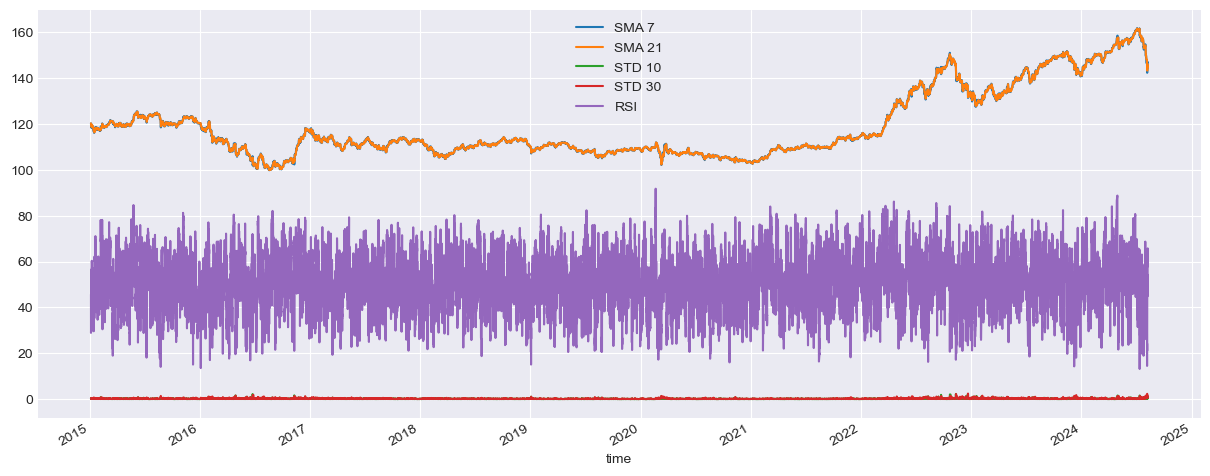

In [57]:
# Plotting the values for the indicators: SMA 7, SMA 21, STD 10, STD 30, and RSI
df_copy[["SMA 7", "SMA 21", "STD 10", "STD 30", "RSI"]].plot(figsize=(15, 6));

# Machine Learning Section

In [59]:
# Splitting the data into features, labels, train and test sets
split = int(0.80 * len(df_copy))

X = df_copy.iloc[:,2:]
y = df_copy["pct_change"]

X_train = X.iloc[:split]
y_train = y.iloc[:split]

X_test = X.iloc[split:]
y_test = y.iloc[split:]

In [60]:
# Here, the data is being standardized so all features have a similar scale, ensuring balanced weights in the ML model

from sklearn.preprocessing import StandardScaler

# Only the feature set (X) needs to be standardized, not the targets (labels)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

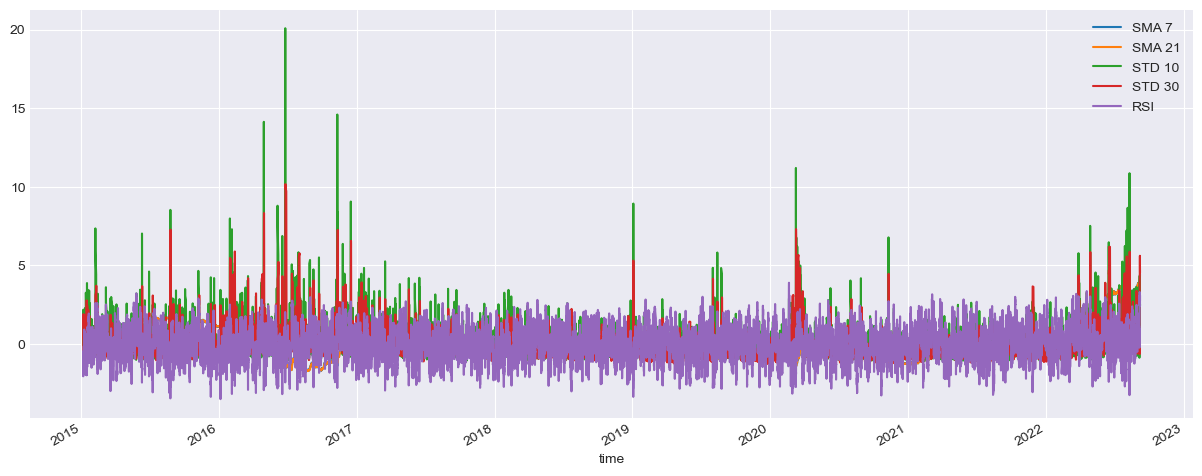

In [90]:
# Plotting the standardized data for the indicators
pd.DataFrame(X_train_scaled, index=X_train.index, columns=X.columns).iloc[:,4:].plot(figsize=(15, 6));

## Training and Fitting the data

In [93]:
from sklearn.linear_model import LinearRegression

In [95]:
regressor = LinearRegression()

# Training the model
regressor.fit(X_train_scaled, y_train)

# Making predictions
predictions = regressor.predict(X_test_scaled)

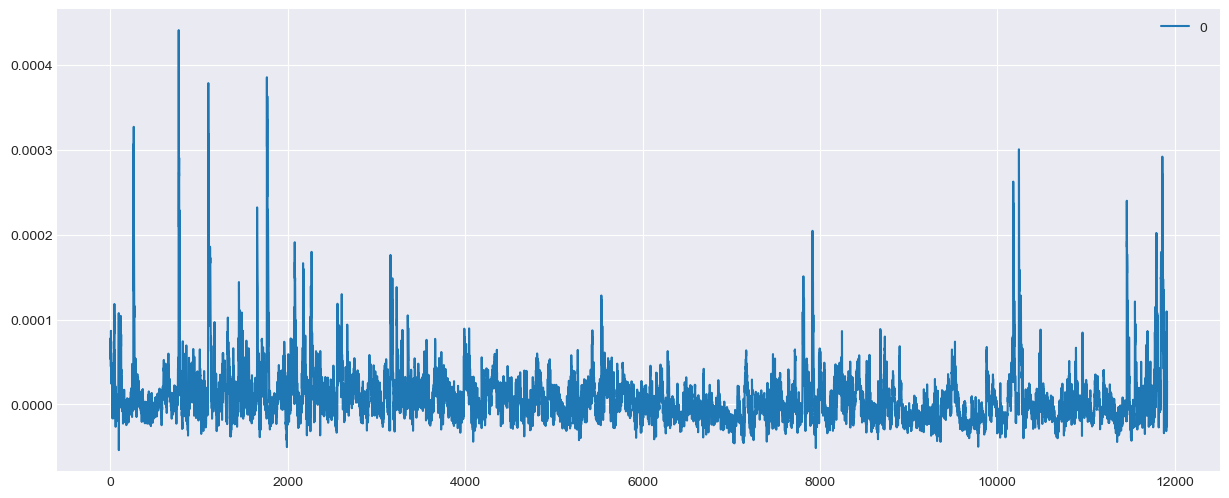

In [97]:
# Plotting to visualize predictions going in both directions
pd.DataFrame(predictions).plot(figsize=(15,6));

In [99]:
predictions.shape

(11916,)

In [101]:
# Here I created a new DataFrame with the percent change which are the labels and the predictions made by the model
df_with_outcomes = df_copy[["pct_change"]].iloc[split:]
df_with_outcomes["prediction"] = predictions
df_with_outcomes

,pct_change,prediction
time,,
2022-09-07 17:00:00,-0.002527,0.000070
2022-09-07 18:00:00,-0.000761,0.000054
2022-09-07 19:00:00,-0.000610,0.000078
2022-09-07 20:00:00,-0.002523,0.000064
2022-09-07 21:00:00,0.001383,0.000053
...,...,...
2024-08-07 12:00:00,0.002548,0.000085
2024-08-07 13:00:00,-0.002582,0.000031
2024-08-07 14:00:00,0.000054,-0.000026


In [107]:
# 2 new columns where added, creating the predictions directions for both real and predicted values 
# So can be compared and find accuracy
df_with_outcomes["real_position"] = np.sign(df_with_outcomes["pct_change"])
df_with_outcomes["pred_position"] = np.sign(df_with_outcomes["prediction"])
df_with_outcomes

,pct_change,prediction,real_position,pred_position
time,,,,
2022-09-07 17:00:00,-0.002527,0.000070,-1.0,1.0
2022-09-07 18:00:00,-0.000761,0.000054,-1.0,1.0
2022-09-07 19:00:00,-0.000610,0.000078,-1.0,1.0
2022-09-07 20:00:00,-0.002523,0.000064,-1.0,1.0
2022-09-07 21:00:00,0.001383,0.000053,1.0,1.0
...,...,...,...,...
2024-08-07 12:00:00,0.002548,0.000085,1.0,1.0
2024-08-07 13:00:00,-0.002582,0.000031,-1.0,1.0
2024-08-07 14:00:00,0.000054,-0.000026,1.0,-1.0


In [109]:
# Calculating the returns by multiplying real percent change and forecasted positions
# Predictions are not shifted by one since all feature were already shifted one row. Predictions are already made with previous bar's data
df_with_outcomes["returns"] = df_with_outcomes["pct_change"] * df_with_outcomes["pred_position"]
df_with_outcomes

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2022-09-07 17:00:00,-0.002527,0.000070,-1.0,1.0,-0.002527
2022-09-07 18:00:00,-0.000761,0.000054,-1.0,1.0,-0.000761
2022-09-07 19:00:00,-0.000610,0.000078,-1.0,1.0,-0.000610
2022-09-07 20:00:00,-0.002523,0.000064,-1.0,1.0,-0.002523
2022-09-07 21:00:00,0.001383,0.000053,1.0,1.0,0.001383
...,...,...,...,...,...
2024-08-07 12:00:00,0.002548,0.000085,1.0,1.0,0.002548
2024-08-07 13:00:00,-0.002582,0.000031,-1.0,1.0,-0.002582
2024-08-07 14:00:00,0.000054,-0.000026,1.0,-1.0,-0.000054


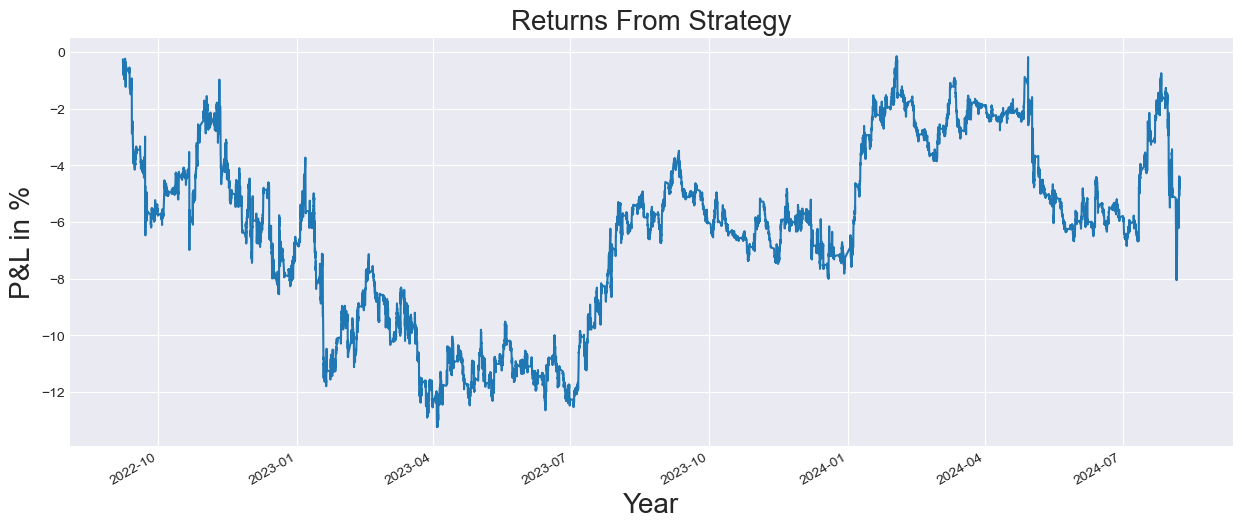

In [111]:
# Plotting the P&l from the Linear Regression Model

(df_with_outcomes["returns"].cumsum()*100).plot(figsize=(15,6))
plt.xlabel('Year', fontsize=20)
plt.ylabel('P&L in %', fontsize=20)
plt.title('Returns From Strategy', fontsize=20)
plt.show()